In [1]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import math
import pandas as pd
from deap import base, creator, tools, algorithms
import logging
import random
import numpy as np
import itertools
import sys
from typing import List, Tuple
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
import os

# pacotes personalizados
import util
from class_manipulate_data import ManipulateData
from class_control_panel import ControlPanel
from ga_K_LightGBM import GA

ga_K_LightGBM - INFO - Módulo util importado com sucesso.


In [2]:
def generate_combinations(variable_dict):
    """
    Generate all possible combinations from the values of a dictionary of variables.

    Args:
    variable_dict (dict): A dictionary where keys are variable names and values are lists of possible values.

    Returns:
    list: A list of tuples, each containing a combination of values from the input lists.
    """
    # Extract lists of values from the dictionary
    lists = variable_dict.values()
    
    # Generate all possible combinations
    combinations = list(itertools.product(*lists))
    
    return combinations

In [3]:
def merge_dict_list(dict_list):
    """
    Merge a list of dictionaries into a single dictionary.
    
    Args:
    dict_list (list): A list of dictionaries where each dictionary has a key 'Antecedent'
                      and contains another dictionary with a variable name and its values.

    Returns:
    dict: A single dictionary with variable names as keys and lists of values as values.
    """
    merged_dict = {}
    for item in dict_list:
        for key, value in item.items():
            merged_dict[key] = value
    return merged_dict

In [4]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
console_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
console_handler = logging.StreamHandler()
console_handler.setFormatter(console_format)
console_handler.setLevel(logging.INFO)
logger.addHandler(console_handler)

file_format = logging.Formatter('%(asctime)s: %(name)s - %(levelname)s - ' +
                                '%(message)s')
log_path = os.path.join(os.getcwd(), 'ga_v2.log')
file_handler = logging.FileHandler(log_path)
file_handler.setFormatter(file_format)
file_handler.setLevel(logging.DEBUG)
logger.addHandler(file_handler)
# endregion

logger.info(util.init())

__main__ - INFO - Módulo util importado com sucesso.


In [5]:
LENGHT_ROI = 125
manipulate_data = ManipulateData()
path_preprocessing_output = manipulate_data.get_path_preprocessing_output()


control_panel = ControlPanel(rolling_mean=False,
                                 window_mean=None,
                                 use_validation_data=False,
                                 number_units_validation=None,
                                 use_optuna=True,
                                 use_savgol_filter=False,
                                 use_roi=True)

control_panel.set_roi(LENGHT_ROI)

In [6]:
# entradas selecionadas pelo algoritmo genético
k=5

input_model = GA(k)

output_model = ['RUL']

equipment_name = 'FD001'

 
set_amounts = 11

set_names = ["Teste1", "Extremely Low", "Very Low", "Low", "Medium High", "Medium", "Medium High", "High", "Very High", "Extremely High", "Teste2"]

ga_K_LightGBM - INFO - ##### K = 5 #####
ga_K_LightGBM - INFO - Lendo os dados de treino.
ga_K_LightGBM - INFO - Lendo os dados de teste.


gen	nevals	avg          	min          	max          
0  	100   	[24.97781382]	[20.69022447]	[30.31704947]
1  	30    	[21.06434247]	[20.36138727]	[21.3364009] 
2  	30    	[20.51050332]	[20.12713432]	[20.90459062]
3  	30    	[20.1744152] 	[19.77881638]	[20.36138727]
4  	30    	[19.96811324]	[19.6045846] 	[20.135202]  
5  	30    	[19.89468868]	[19.6045846] 	[19.99357295]
6  	30    	[19.74941492]	[19.6045846] 	[19.87488416]
7  	30    	[19.69896183]	[19.6045846] 	[19.76676414]
8  	30    	[19.68009105]	[19.6045846] 	[19.74967694]
9  	30    	[19.63627156]	[19.52899396]	[19.7290159] 
10 	30    	[19.59405068]	[19.52899396]	[19.65136052]
11 	30    	[19.57063464]	[19.43731731]	[19.61090444]
12 	30    	[19.55134895]	[19.43731731]	[19.6045846] 
13 	30    	[19.52225676]	[19.43731731]	[19.59078726]
14 	30    	[19.52225676]	[19.43731731]	[19.59078726]
15 	30    	[19.48866097]	[19.43731731]	[19.55652063]
16 	30    	[19.4859083] 	[19.43731731]	[19.55652063]
17 	30    	[19.44648497]	[19.43731731]	[19.528

ga_K_LightGBM - INFO - K = 5
ga_K_LightGBM - INFO - hof: 19.437 << ['sensor_11', 'sensor_9', 'sensor_7', 'sensor_12', 'time']


25 	30    	[19.43731731]	[19.43731731]	[19.43731731]
sensor_11 sensor_9 sensor_7 sensor_12 time


In [7]:
logger.info("Lendo os dados de treino.")

path_dataset_train = \
    str(path_preprocessing_output.joinpath(f"train_{equipment_name}.parquet"))

df_train = pd.read_parquet(path_dataset_train)
df_train = control_panel.apply_roi(df_train, output_model[0], LENGHT_ROI)

logger.info("Lendo os dados de teste.")

path_dataset_test = \
    str(path_preprocessing_output.joinpath(f"test_{equipment_name}.parquet"))

df_test = pd.read_parquet(path_dataset_test)
df_test = control_panel.apply_roi(df_test, output_model[0], LENGHT_ROI)

__main__ - INFO - Lendo os dados de treino.
__main__ - INFO - Lendo os dados de teste.


In [8]:
df_train = df_train[input_model + output_model].copy()

df_test = df_test[input_model + output_model].copy()

In [9]:
var_linguisticas = []
for input in input_model:
    min_train = df_train[input].min()
    min_test = df_test[input].min()
    if min_test < min_train:
        min_r = min_test
    else:
        min_r = min_train

    max_train = df_train[input].max()
    max_test = df_test[input].max()
    if max_test < max_train:
        max_r = max_train
    else:
        max_r = max_test
    aux = {}
    aux["name"] = input
    aux["min"] = math.floor(min_r) - 1
    aux["max"] = math.ceil(max_r) + 1
    aux["step"] = 0.01
    var_linguisticas.append(aux)

In [10]:
for var in var_linguisticas:
    var["antecedente"] = ctrl.Antecedent(np.arange(var["min"], var["max"], var["step"]), var["name"])
    var["antecedente"].automf(set_amounts, names=set_names)

RUL = ctrl.Consequent(np.arange(math.floor(df_train[output_model].values.min()),
                                math.ceil(df_train[output_model].values.max()) + 1,
                                0.01),
                                output_model[0],
                                defuzzify_method='centroid')
RUL.automf(set_amounts, names=set_names)

In [11]:
def manter_regras_com_maior_DR_j(regras):
    antecedentes_para_regras = {}

    # Passo 1: Criar um dicionário mapeando antecedentes para as regras com consequentes diferentes
    for regra in regras:
        antecedentes = tuple(regra['antecedentes'])
        consequente = regra['consequente']
        if antecedentes not in antecedentes_para_regras:
            antecedentes_para_regras[antecedentes] = {'regras': [regra], 'maior_DR_j': regra['DR_j']}
        else:
            antecedentes_para_regras[antecedentes]['regras'].append(regra)
            if regra['DR_j'] > antecedentes_para_regras[antecedentes]['maior_DR_j']:
                antecedentes_para_regras[antecedentes]['maior_DR_j'] = regra['DR_j']

    # Passo 2: Criar uma nova lista de regras com os maiores DR_j
    novas_regras = []
    for antecedentes, info in antecedentes_para_regras.items():
        maior_DR_j = info['maior_DR_j']
        regras_com_maior_DR_j = [regra for regra in info['regras'] if regra['DR_j'] == maior_DR_j]
        novas_regras.extend(regras_com_maior_DR_j)

    return novas_regras

In [12]:
logger.info("Extraindo as regras")
regras = []
for indice, data in df_train.iterrows():
    DR_j = 1
    regra = {}
    # antecedente
    regra["antecedentes"] = []
    for var in var_linguisticas:
        valor = data[var["name"]]
        grau_max = 0
        conj_max = None
        for conjunto in var["antecedente"].terms:
            grau_pertinencia = fuzz.interp_membership(var["antecedente"].universe, var["antecedente"][conjunto].mf, valor)
            if grau_pertinencia > grau_max:
                grau_max = grau_pertinencia
                conj_max = conjunto
        DR_j = DR_j * grau_max

        regra["antecedentes"].append(var["antecedente"][conj_max])

    # consequente
    valor = data["RUL"]
    grau_max = 0
    conj_max = None
    for conjunto in RUL.terms:
        grau_pertinencia = fuzz.interp_membership(RUL.universe, RUL[conjunto].mf, valor)
        if grau_pertinencia > grau_max:
            grau_max = grau_pertinencia
            conj_max = conjunto
    DR_j = DR_j * grau_max
    regra["DR_j"] = DR_j
    regra["consequente"] = RUL[conj_max]
    regras.append(regra)

__main__ - INFO - Extraindo as regras


In [13]:
logger.info("Filtrando as regras")
novas_regras = manter_regras_com_maior_DR_j(regras)

# %%
logger.info(f"São {len(novas_regras)} regras após a filtragem.")

# %%
ctrl_rule = []
# Combine os antecedentes usando o operador E ("&")
for regra in novas_regras:
    antecedentes = regra["antecedentes"]
    consequente = regra["consequente"]
    regra_aux = antecedentes[0]
    for antecedente in antecedentes[1:]:
        regra_aux = regra_aux & antecedente

    # Combine o antecedente com o consequente
    # regra_final = regra >> consequente

    # Adicione a regra ao controlador (se necessário)
    ctrl_rule.append(ctrl.Rule(regra_aux, consequente))

__main__ - INFO - Filtrando as regras
__main__ - INFO - São 943 regras após a filtragem.


In [14]:
len(ctrl_rule)

943

In [15]:
logger.info("Criando o sistema de controle")
sistema_controle = ctrl.ControlSystem(ctrl_rule)
controle = ctrl.ControlSystemSimulation(sistema_controle)

# %%
data = df_train.iloc[0]

__main__ - INFO - Criando o sistema de controle


In [16]:
def func_rules_activated(data, var_linguisticas):
    rules_activated = {}
        # antecedente
    #rules_activated["antecedentes"] = []
    rules_activated = []
    DR_j = 1
    for var in var_linguisticas:
        valor = data[var["name"]]

        set_activated = {}
        set_activated[var["antecedente"]] = []
        for conjunto in var["antecedente"].terms:
            grau_pertinencia = fuzz.interp_membership(var["antecedente"].universe, var["antecedente"][conjunto].mf, valor)
            if grau_pertinencia > 0:
                set_activated[var["antecedente"]].append(var["antecedente"][conjunto])

        rules_activated.append(set_activated)

    merged_dict = merge_dict_list(rules_activated)

    possible_rules = generate_combinations(merged_dict)

    for nova_regra in novas_regras:
        for possible_rule in possible_rules:
            if possible_rule == tuple(nova_regra["antecedentes"]):
                print(nova_regra)

# Example: RUL equal 121

In [17]:
data = df_train.iloc[70]
data

sensor_11      47.30
sensor_9     9046.09
sensor_7      554.06
sensor_12     521.72
time           71.00
RUL           121.00
Name: 70, dtype: float64

In [18]:
for var in var_linguisticas:
    valor = data[var["name"]]
    controle.input[var["name"]] = valor
controle.compute()

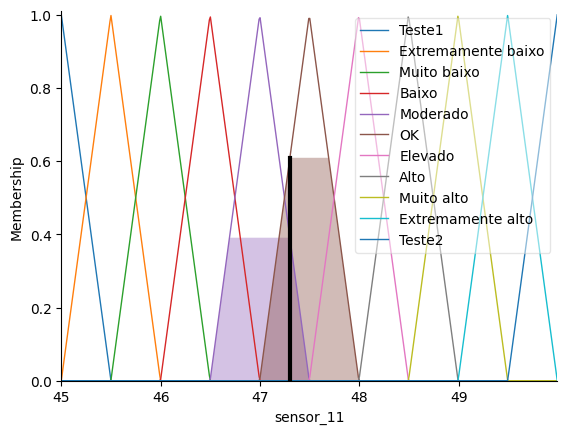

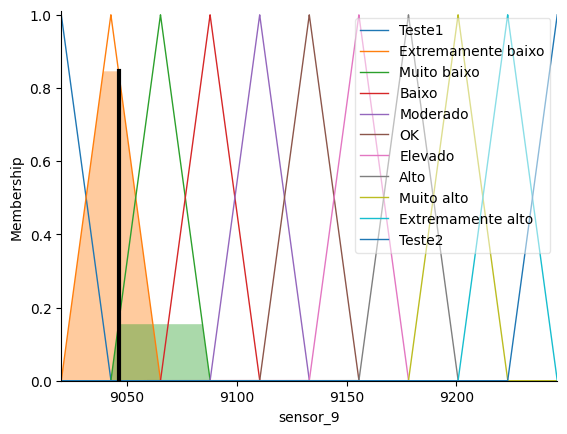

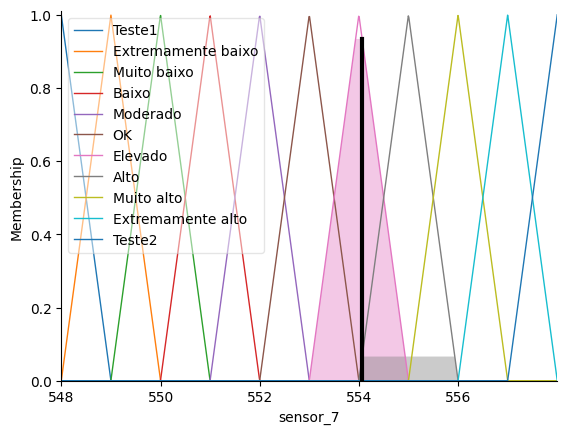

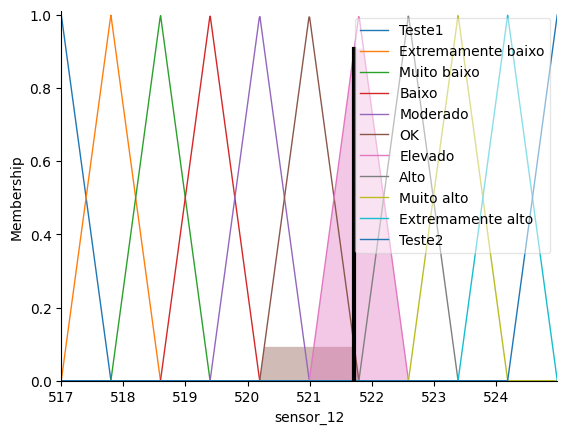

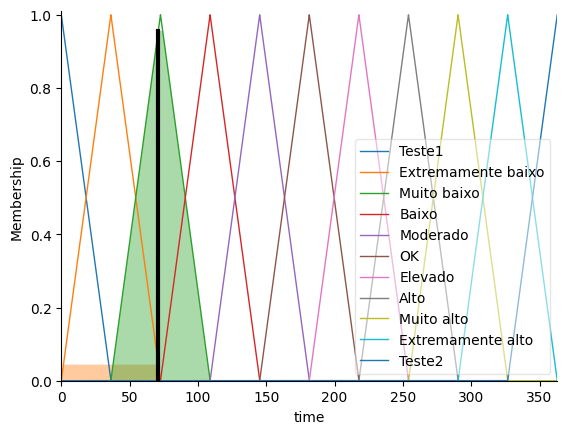

In [19]:
for var in var_linguisticas:
    var["antecedente"].view(sim=controle)

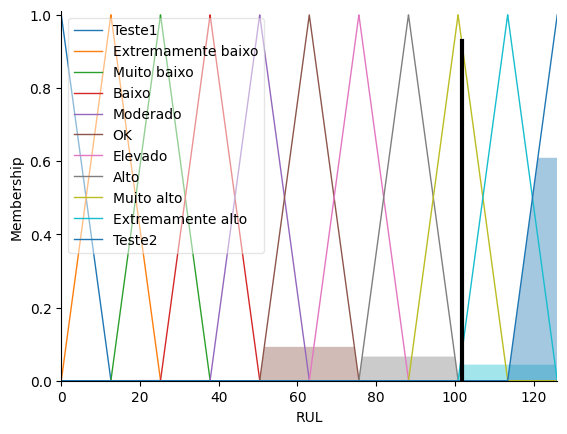

In [20]:
RUL.view(sim=controle)

In [21]:
controle.output['RUL']

101.70287848147666

In [22]:
func_rules_activated(data, var_linguisticas)

{'antecedentes': [sensor_11[OK], sensor_9[Muito baixo], sensor_7[Elevado], sensor_12[Elevado], time[Extremamente baixo]], 'DR_j': 0.691665223717209, 'consequente': RUL[Teste2]}
{'antecedentes': [sensor_11[Moderado], sensor_9[Extremamente baixo], sensor_7[Alto], sensor_12[Elevado], time[Extremamente baixo]], 'DR_j': 0.2338295874724806, 'consequente': RUL[Teste2]}
{'antecedentes': [sensor_11[Moderado], sensor_9[Muito baixo], sensor_7[Elevado], sensor_12[Elevado], time[Extremamente baixo]], 'DR_j': 0.4468392877515805, 'consequente': RUL[Teste2]}
{'antecedentes': [sensor_11[OK], sensor_9[Extremamente baixo], sensor_7[Elevado], sensor_12[Elevado], time[Extremamente baixo]], 'DR_j': 0.5841147588913772, 'consequente': RUL[Teste2]}
{'antecedentes': [sensor_11[OK], sensor_9[Extremamente baixo], sensor_7[Alto], sensor_12[Elevado], time[Extremamente baixo]], 'DR_j': 0.3309389392281908, 'consequente': RUL[Teste2]}
{'antecedentes': [sensor_11[Moderado], sensor_9[Extremamente baixo], sensor_7[Elevad

# Example: RUL equal 21

In [23]:
data = df_train.iloc[170]
data

sensor_11      48.03
sensor_9     9042.12
sensor_7      552.71
sensor_12     519.85
time          171.00
RUL            21.00
Name: 170, dtype: float64

In [24]:
for var in var_linguisticas:
    valor = data[var["name"]]
    controle.input[var["name"]] = valor
controle.compute()

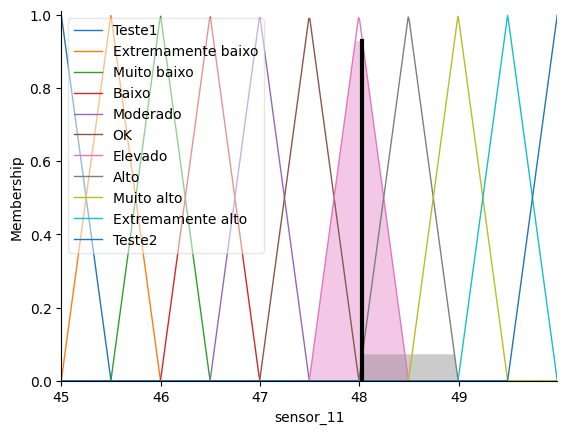

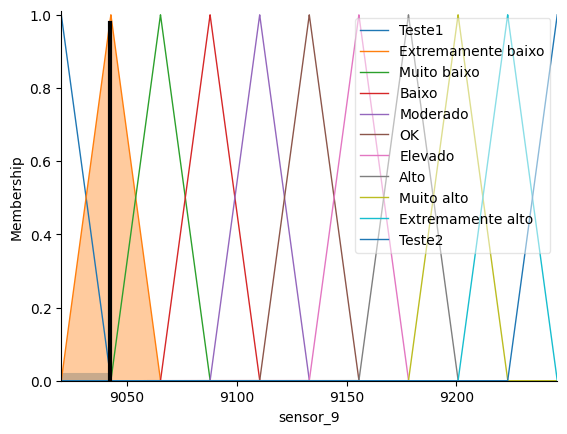

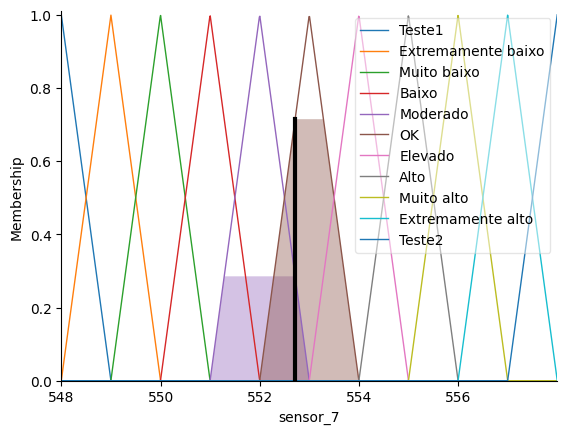

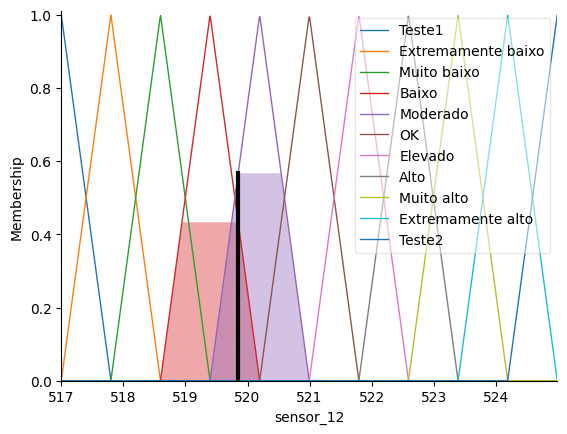

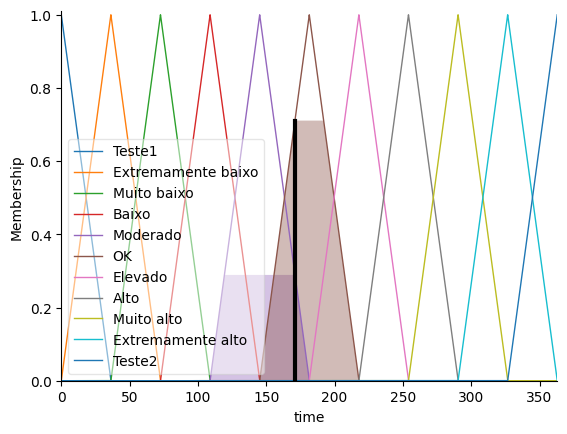

In [25]:
for var in var_linguisticas:
    var["antecedente"].view(sim=controle)

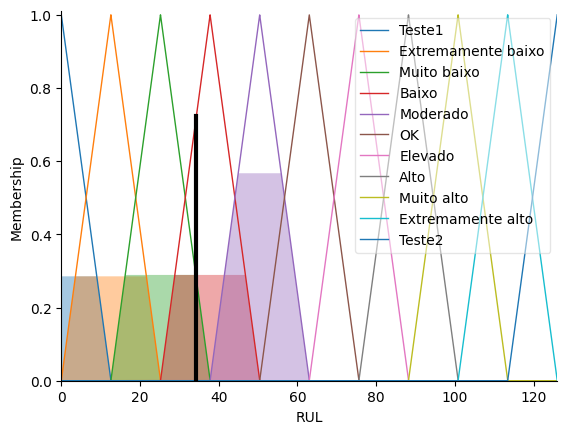

In [26]:
RUL.view(sim=controle)

In [27]:
controle.output['RUL']

34.326256383096116

In [28]:
data

sensor_11      48.03
sensor_9     9042.12
sensor_7      552.71
sensor_12     519.85
time          171.00
RUL            21.00
Name: 170, dtype: float64

In [29]:
func_rules_activated(data, var_linguisticas)

{'antecedentes': [sensor_11[Elevado], sensor_9[Extremamente baixo], sensor_7[Moderado], sensor_12[Moderado], time[Moderado]], 'DR_j': 0.5814728217912575, 'consequente': RUL[Extremamente baixo]}
{'antecedentes': [sensor_11[Elevado], sensor_9[Extremamente baixo], sensor_7[OK], sensor_12[Moderado], time[Moderado]], 'DR_j': 0.46375556196865425, 'consequente': RUL[Baixo]}
{'antecedentes': [sensor_11[Elevado], sensor_9[Extremamente baixo], sensor_7[Moderado], sensor_12[Moderado], time[OK]], 'DR_j': 0.5423745386583758, 'consequente': RUL[Extremamente baixo]}
{'antecedentes': [sensor_11[Elevado], sensor_9[Extremamente baixo], sensor_7[OK], sensor_12[Moderado], time[OK]], 'DR_j': 0.3000093838409534, 'consequente': RUL[Moderado]}
{'antecedentes': [sensor_11[Elevado], sensor_9[Extremamente baixo], sensor_7[Moderado], sensor_12[Baixo], time[OK]], 'DR_j': 0.4216641301906824, 'consequente': RUL[Teste1]}
{'antecedentes': [sensor_11[Elevado], sensor_9[Teste1], sensor_7[OK], sensor_12[Moderado], time[M